<a href="https://colab.research.google.com/github/hajyhia/Plant-Diseases-Classification/blob/main/crops_detection_using_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle
!pip install tensorflow

link dataset https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset

# Download dataset

In [2]:
import os
os.environ['KAGGLE_USERNAME'] = 'username'
os.environ['KAGGLE_KEY'] = 'key'

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shehabhajyahia","key":"89366cc6c091dc7c2d250e3665c21252"}'}

In [3]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset
!unzip new-plant-diseases-dataset.zip -d new-plant-diseases-dataset/ > /dev/null 2>&1
!rm -rf '/content/new-plant-diseases-dataset/new plant diseases dataset(augmented)'

Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors
100% 2.70G/2.70G [00:17<00:00, 229MB/s]
100% 2.70G/2.70G [00:17<00:00, 166MB/s]


## Unzip dataset and folder set up

# ***Import Libarys***

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.optimizers import Adam


from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.applications.resnet import ResNet101
from tensorflow.keras.applications import ResNet50
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import EfficientNetV2L

import random
import os
import warnings
warnings.filterwarnings('ignore')
print('compelet')

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

# create working directoy
os.makedirs('/content/working', exist_ok=True)

compelet
Num GPUs Available: 1


# ***Data understanding & Visualization***

In [5]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

np.random.seed(42)
tf.random.set_seed(42)

# Parameters
image_shape = (224, 224)
batch_size = 64
epochs = 25  # Adjust as needed
data_path = '/content/new-plant-diseases-dataset/'

# Paths (make sure data_path is defined)
train_folder = os.path.join(data_path, 'New Plant Diseases Dataset(Augmented)', 'New Plant Diseases Dataset(Augmented)', 'train')
valid_folder = os.path.join(data_path, 'New Plant Diseases Dataset(Augmented)', 'New Plant Diseases Dataset(Augmented)', 'valid')

# Image generators
train_datagen = ImageDataGenerator(rescale=1/255., validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load training data
print("Training Images:")
train_data = train_datagen.flow_from_directory(train_folder,
                                               target_size=image_shape,
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset='training')

# Load validation data
print("Validating Images:")
valid_data = train_datagen.flow_from_directory(train_folder,
                                               target_size=image_shape,
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=False,
                                               subset='validation')

# Load test data (separate validation folder)
print("Test Images:")
test_data = test_datagen.flow_from_directory(valid_folder,
                                             target_size=image_shape,
                                             batch_size=batch_size,
                                             class_mode='categorical',
                                             shuffle=False)


Training Images:
Found 56251 images belonging to 38 classes.
Validating Images:
Found 14044 images belonging to 38 classes.
Test Images:
Found 17572 images belonging to 38 classes.


***From previous cell we know that we have 38 class***
> * 56251 images in train data
> * 14044 images in validation data
> * 17572 images in test data
> * 33 imgeas in test data (the label of test data is the name of image) we will uses them to predict later

***But what are 38 classes ?!***

In [6]:
# show how data store
images, labels = next(iter(train_data))
print(f'shape of image is : {images[0].shape}')

shape of image is : (224, 224, 3)


In [7]:
# Show all diseases (class names) in the dataset
diseases = os.listdir(train_folder)
print(f"Diseases in dataset {len(diseases)}:")
print(diseases)

Diseases in dataset 38:
['Strawberry___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Bacterial_spot', 'Corn_(maize)___Common_rust_', 'Tomato___Late_blight', 'Tomato___Early_blight', 'Soybean___healthy', 'Peach___Bacterial_spot', 'Strawberry___Leaf_scorch', 'Pepper,_bell___healthy', 'Apple___Black_rot', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Cherry_(including_sour)___Powdery_mildew', 'Raspberry___healthy', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Pepper,_bell___Bacterial_spot', 'Orange___Haunglongbing_(Citrus_greening)', 'Blueberry___healthy', 'Tomato___Septoria_leaf_spot', 'Grape___healthy', 'Peach___healthy', 'Apple___Cedar_apple_rust', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Tomato___healthy', 'Apple___healthy', 'Cherry_(including_sour)___healthy', 'Tomato___Leaf_Mold', 'Potato___Early_blight', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Squash___Powdery_mildew', 'Potato___healt

***We notice that we have the same plant in different class such as:***
 > * Tomato___Early_blight
 > * Tomato___Late_blight
 > * Tomato___healthy
 > * ...

***so we need to know what is the different type of plant we have***

In [8]:
# identify uniqe plant in dataset
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
print(f'number of different plants is :{len(plants)}')
print(plants)

number of different plants is :14
['Strawberry', 'Corn_(maize)', 'Tomato', 'Soybean', 'Peach', 'Pepper,_bell', 'Apple', 'Cherry_(including_sour)', 'Raspberry', 'Orange', 'Blueberry', 'Grape', 'Potato', 'Squash']


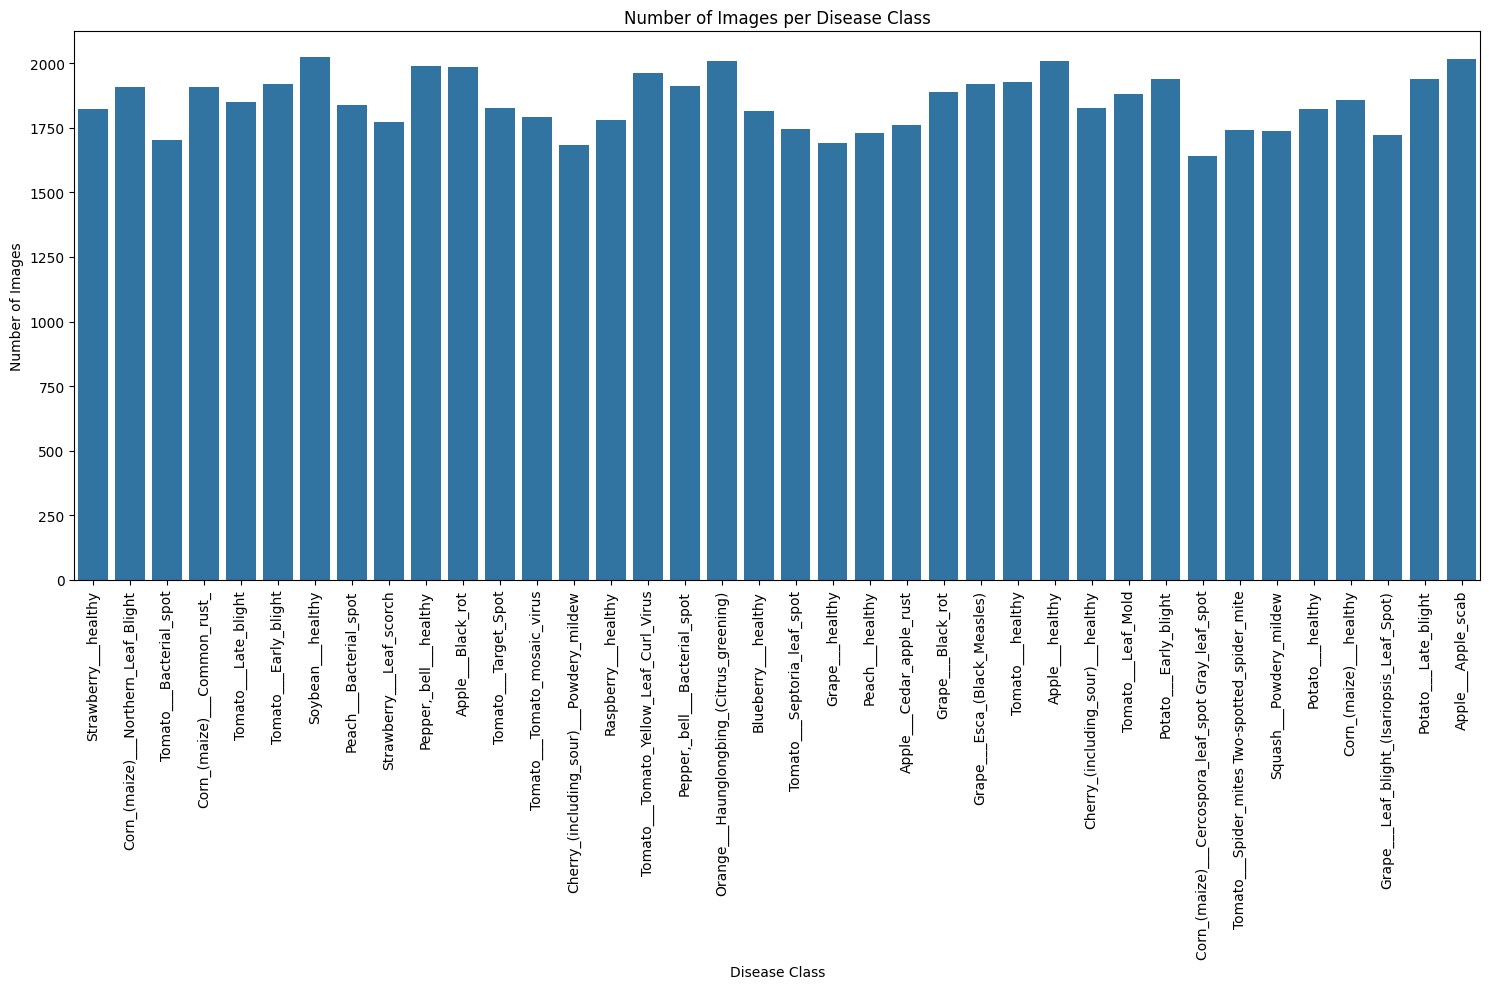

In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create dictionary of class counts
dic = {}
for disease_class in diseases:
    class_path = os.path.join(train_folder, disease_class)
    dic[disease_class] = len(os.listdir(class_path))

# Convert to DataFrame
df = pd.DataFrame(list(dic.items()), columns=["Disease Class", "Number of Images"])

# Optional: sort by number of images
# df = df.sort_values(by="Number of Images", ascending=False)

# Plot
plt.figure(figsize=(15, 10))
sns.barplot(data=df, x='Disease Class', y='Number of Images')
plt.xticks(rotation=90)
plt.title("Number of Images per Disease Class")
plt.tight_layout()
plt.show()

***As we notice that classes are somewhat balanced***

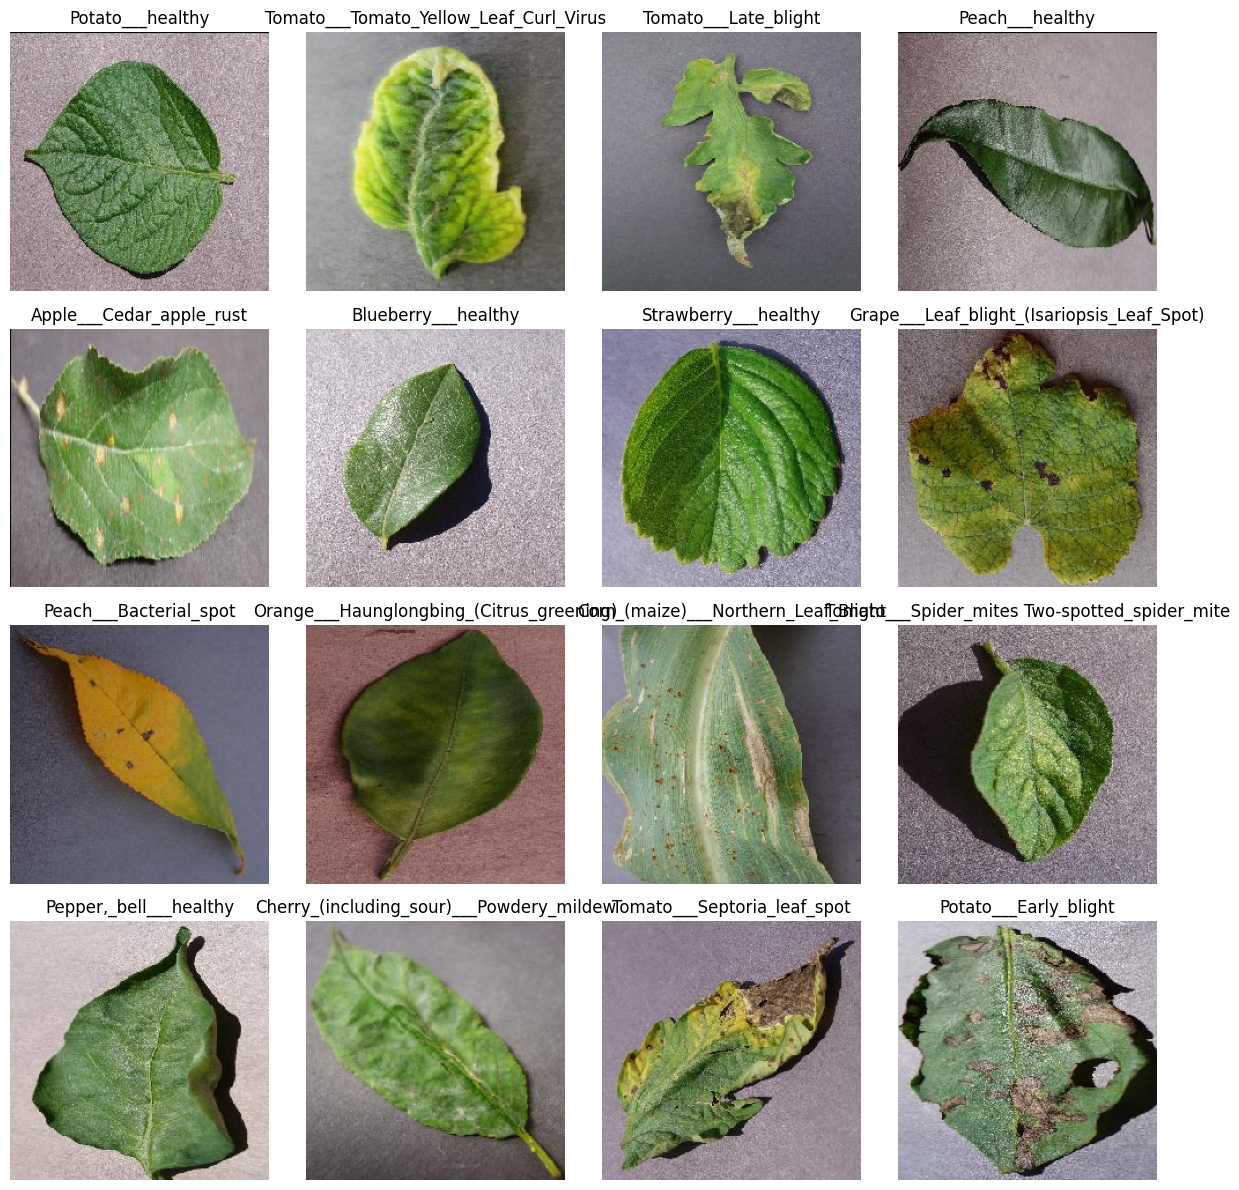

In [10]:
import random
import numpy as np

# select a specific batch
images, labels = next(iter(train_data))

# select 16 image by random
indices = random.sample(range(len(images)), 16)
selected_images = images[indices]
selected_labels = labels[indices]

class_names = list(train_data.class_indices.keys())

# plotting
plt.figure(figsize=(12, 12))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(selected_images[i])
    plt.title(class_names[np.argmax(selected_labels[i])])
    plt.axis("off")

plt.tight_layout()
plt.show()

# ***Modeling***

***Function will be used***

Learning curve function
> * learning curve
> * loss curve

In [11]:
def plot_learning_curves(history):
    plt.figure(figsize=(12, 4))

    # accuracy curve
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # loss curve
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


Prediction function
> Compare Truth label (name of image ) with predicted label

In [12]:
def predict_labels_and_display(model_path, test_dir='/content/new-plant-diseases-dataset/test/test', image_size=(224, 224)):
    # load the best model
    best_model = load_model(model_path)

    true_labels = []
    predicted_labels = []
    images = []

    for filename in os.listdir(test_dir):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            # load test images
            img_path = os.path.join(test_dir, filename)
            img = image.load_img(img_path, target_size=image_size)
            img_array = image.img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)

            # predict
            prediction = best_model.predict(img_array, verbose=0)
            predicted_class = np.argmax(prediction, axis=1)[0]

            # extract the label (name of image)
            true_label = filename.split('.')[0]

            # get the prediction class
            class_labels = list(train_data.class_indices.keys())
            predicted_label = class_labels[predicted_class]

            true_labels.append(true_label)
            predicted_labels.append(predicted_label)
            images.append(img)

    # randomly select three images
    selected_indices = random.sample(range(len(images)), 3)

    # show selected images
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(selected_indices):
        plt.subplot(1, 3, i + 1)
        plt.imshow(images[idx])
        plt.title(f'True: {true_labels[idx]}\nPredicted: {predicted_labels[idx]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [13]:
diseases_class = list(train_data.class_indices.keys())

with open("/content/working/diseases_labels", "w") as f:
    for itm in diseases_class:
        f.write(itm + "\n")

# ***CNN Model***

In [34]:
# Model Architecture
model = Sequential()

model.add(Conv2D(32,(3,3),activation = 'relu',input_shape=(224,224,3), kernel_initializer=GlorotNormal()))
model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer=GlorotNormal()))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer=GlorotNormal()))
model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer=GlorotNormal()))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer=GlorotNormal()))
model.add(Conv2D(256, (3,3), activation='relu', kernel_initializer=GlorotNormal()))
model.add(MaxPooling2D(2,2))

# model.add(Flatten())
model.add(GlobalAveragePooling2D())

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(38, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 220, 220, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 49, 49, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 744,966 (2.84 MB)

 Trainable params: 743,046 (2.83 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [38]:
len(model.layers)

23

In [48]:
for layer in model.layers:
    print(layer.name, layer.trainable)
    layer.trainable_variables

conv2d_6 True
conv2d_7 True
max_pooling2d_3 True
conv2d_8 True
conv2d_9 True
max_pooling2d_4 True
conv2d_10 True
conv2d_11 True
max_pooling2d_5 True
global_average_pooling2d_3 True
dense_11 True
batch_normalization_8 True
dropout_8 True
dense_12 True
batch_normalization_9 True
dropout_9 True
dense_13 True
batch_normalization_10 True
dropout_10 True
dense_14 True
batch_normalization_11 True
dropout_11 True
dense_15 True


## Train Model

In [15]:
# train the model
model_checkpoint = ModelCheckpoint('/content/working/cnn_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, mode='max', restore_best_weights=True)

history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint, early_stopping])

Epoch 1/25
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.1668 - loss: 3.0998
Epoch 1: val_accuracy improved from -inf to 0.22615, saving model to /content/working/cnn_model.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 295s 303ms/step - accuracy: 0.1669 - loss: 3.0992 - val_accuracy: 0.2261 - val_loss: 3.0870
Epoch 2/25
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.4627 - loss: 1.7468
Epoch 2: val_accuracy improved from 0.22615 to 0.61215, saving model to /content/working/cnn_model.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 237s 270ms/step - accuracy: 0.4628 - loss: 1.7466 - val_accuracy: 0.6121 - val_loss: 1.2116
Epoch 3/25
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.5883 - loss: 1.2955
Epoch 3: val_accuracy did not improve from 0.61215
879/879 ━━━━━━━━━━━━━━━━━━━━ 237s 270ms/step - accuracy: 0.5883 - loss: 1.2954 - val_accuracy: 0.4717 - val_loss: 1.8416
Epoch 4/25
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.6873 - loss: 0.9852
Epoch 4: val_accuracy impro

In [16]:
#  save model to use later
keras_model_file = '/content/working/cnn_crops_model.keras'
model.save(keras_model_file)

## Run Evaluate

In [17]:
best_model = load_model(keras_model_file)

test_loss, test_accuracy = best_model.evaluate(test_data)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

275/275 ━━━━━━━━━━━━━━━━━━━━ 49s 176ms/step - accuracy: 0.9298 - loss: 0.2128
Test Loss: 0.2443
Test Accuracy: 0.9191


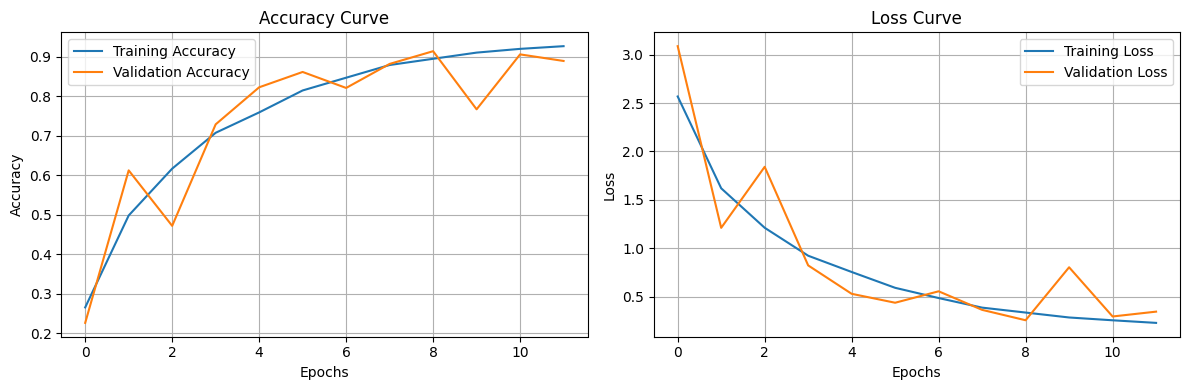

In [18]:
plot_learning_curves(history)

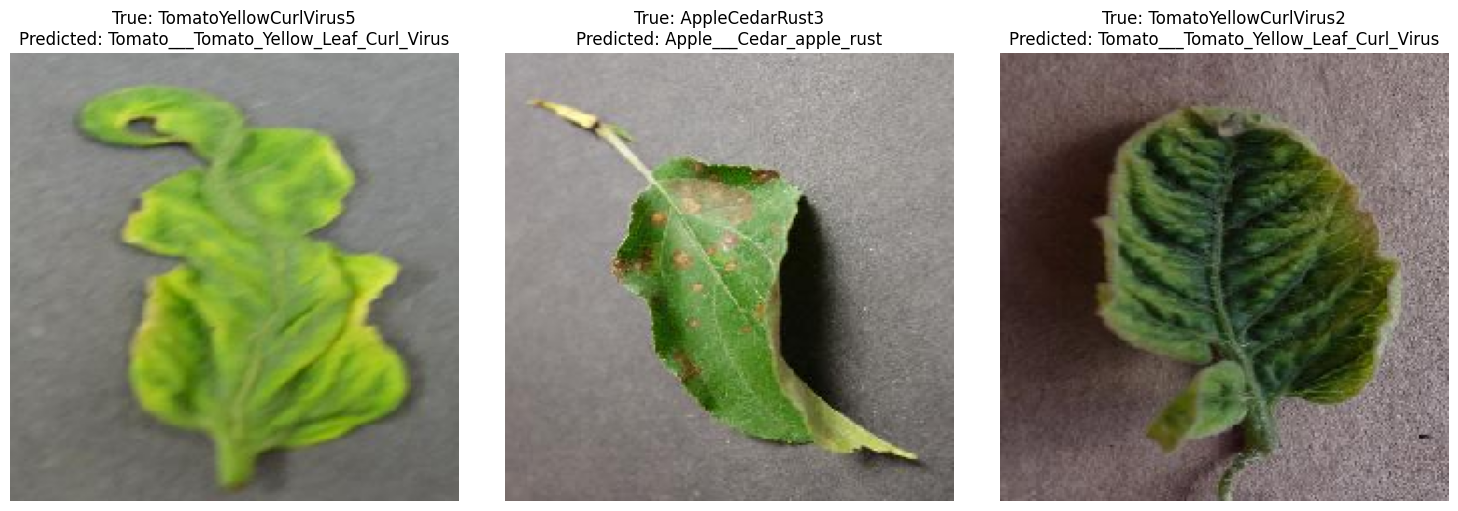

In [19]:
# show random sample of prediction of model on test data
predict_labels_and_display(keras_model_file)

# Customized Pre-Trained Model

In [20]:
models_dict = {
"Xception": tf.keras.applications.Xception,

"VGG16": tf.keras.applications.VGG16,

"VGG19": tf.keras.applications.VGG19,

"ResNet50": tf.keras.applications.ResNet50,

"ResNet101": tf.keras.applications.ResNet101,

"ResNet152": tf.keras.applications.ResNet152,

"InceptionV3": tf.keras.applications.InceptionV3,

"MobileNet": tf.keras.applications.MobileNet,

"MobileNetV2": tf.keras.applications.MobileNetV2,
"DenseNet121": tf.keras.applications.DenseNet121,
"DenseNet169": tf.keras.applications.DenseNet169,

"DenseNet201": tf.keras.applications.DenseNet201,

"NASNetMobile": tf.keras.applications.NASNetMobile,

"NASNetLarge": tf.keras.applications.NASNetLarge,

"EfficientNetB0": tf.keras.applications.EfficientNetB0,

"EfficientNetB1": tf.keras.applications.EfficientNetB1,

"EfficientNetB2": tf.keras.applications.EfficientNetB2,

"EfficientNetB3": tf.keras.applications.EfficientNetB3,

"EfficientNetB4": tf.keras.applications.EfficientNetB4,

"EfficientNetB5": tf.keras.applications.EfficientNetB5,
"EfficientNetB6": tf.keras.applications.EfficientNetB6,
"EfficientNetB7": tf.keras.applications.EfficientNetB7
}

In [33]:
# Define input shape
input_shape = (224, 224, 3)  # Adjust height, width, and channels as needed


# Define inputs
inputs = tf.keras.Input(shape=input_shape)
print(inputs )
model_name='MobileNetV2'
# Load the base model
base_model = models_dict[model_name](weights='imagenet', include_top=False, input_tensor=inputs)
# Freeze the base model layers
base_model.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(38, activation='softmax')(x)
# Create model
pre_trained_model = tf.keras.models.Model(inputs = inputs, outputs = outputs)

# Compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

pre_trained_model.compile(loss="categorical_crossentropy", optimizer= optimizer, metrics=["accuracy",'precision','recall'])

# Display summary
pre_trained_model.summary()

<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, name=keras_tensor_1655>


Model: "functional_70"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,606,118 (9.94 MB)

 Trainable params: 347,494 (1.33 MB)

 Non-trainable params: 2,258,624 (8.62 MB)

## Train Model

In [22]:
# train the model

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max' , restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/working/cnn_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
# model_ReduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.000001)

callbacks=[early_stopping, model_checkpoint]
# callbacks=[early_stopping, model_checkpoint, model_ReduceLROnPlateau]

history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint, early_stopping])

Epoch 1/25
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.6915 - loss: 1.2171 - precision: 0.9086 - recall: 0.5125
Epoch 1: val_accuracy improved from -inf to 0.91819, saving model to /content/working/cnn_model.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 187s 198ms/step - accuracy: 0.6916 - loss: 1.2165 - precision: 0.9086 - recall: 0.5127 - val_accuracy: 0.9182 - val_loss: 0.2661 - val_precision: 0.9446 - val_recall: 0.8919
Epoch 2/25
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9088 - loss: 0.2998 - precision: 0.9387 - recall: 0.8767
Epoch 2: val_accuracy improved from 0.91819 to 0.92887, saving model to /content/working/cnn_model.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 157s 179ms/step - accuracy: 0.9088 - loss: 0.2998 - precision: 0.9387 - recall: 0.8767 - val_accuracy: 0.9289 - val_loss: 0.2112 - val_precision: 0.9457 - val_recall: 0.9173
Epoch 3/25
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9230 - loss: 0.2415 - precision: 0.9443 - recall: 0.9030
Epoch 3: val

In [23]:
#  save model to use later
keras_model_file = f'/content/working/cnn_crops_{model_name}.keras'
model.save(keras_model_file)

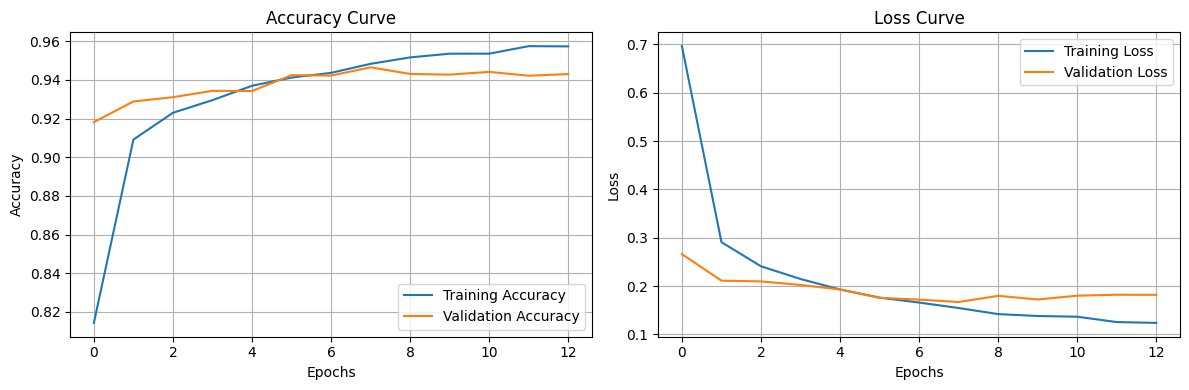

In [24]:
plot_learning_curves(history)

## Run Evaluate

In [25]:
best_model = load_model(keras_model_file)

test_dict  = best_model.evaluate(test_data, return_dict = True)
print(f"Test Accuracy: {test_dict['accuracy']:.4f}")
print(f"Test Loss: {test_dict['loss']:.4f}")
print(f"Test Precision: {test_dict['precision']:.4f}")
print(f"Test Recall: {test_dict['recall']:.4f}")

275/275 ━━━━━━━━━━━━━━━━━━━━ 48s 156ms/step - accuracy: 0.9734 - loss: 0.0844 - precision: 0.9772 - recall: 0.9711
Test Accuracy: 0.9571
Test Loss: 0.1342
Test Precision: 0.9650
Test Recall: 0.9515


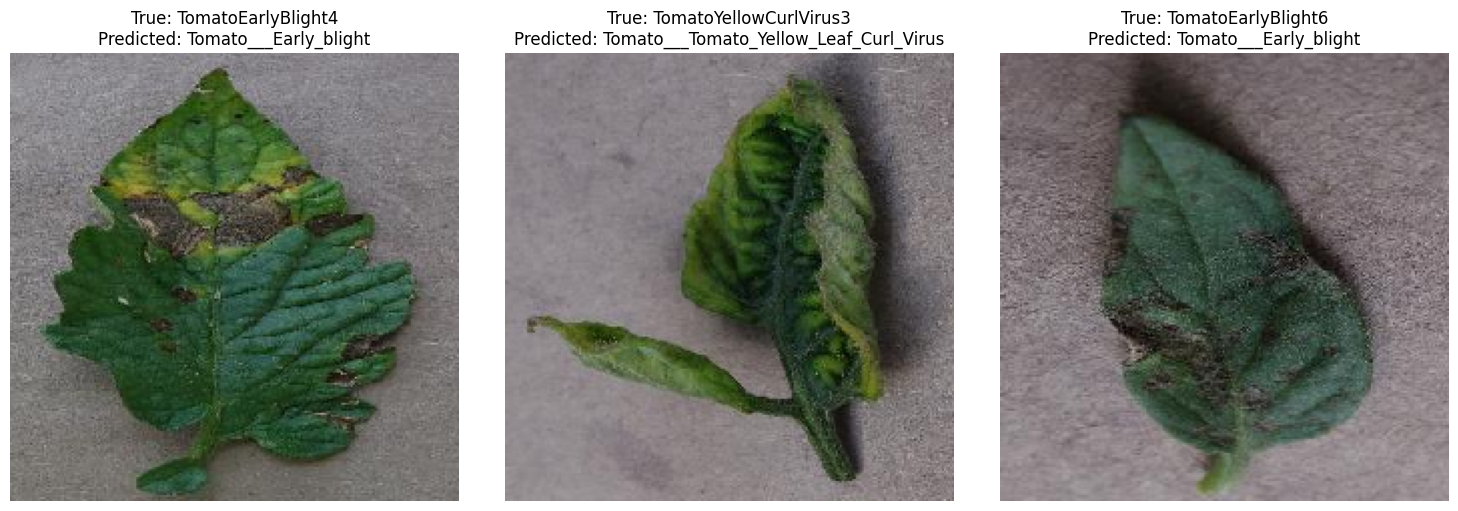

In [26]:
# show random sample of prediction of model on test data
predict_labels_and_display(keras_model_file)